In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error


In [5]:
data = pd.read_csv("/content/Energy_consumption.csv")

data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data.set_index('Timestamp', inplace=True)

print(data.head())


                     Temperature   Humidity  SquareFootage  Occupancy  \
Timestamp                                                               
2022-01-01 00:00:00    25.139433  43.431581    1565.693999          5   
2022-01-01 01:00:00    27.731651  54.225919    1411.064918          1   
2022-01-01 02:00:00    28.704277  58.907658    1755.715009          2   
2022-01-01 03:00:00    20.080469  50.371637    1452.316318          1   
2022-01-01 04:00:00    23.097359  51.401421    1094.130359          9   

                    HVACUsage LightingUsage  RenewableEnergy  DayOfWeek  \
Timestamp                                                                 
2022-01-01 00:00:00        On           Off         2.774699     Monday   
2022-01-01 01:00:00        On            On        21.831384   Saturday   
2022-01-01 02:00:00       Off           Off         6.764672     Sunday   
2022-01-01 03:00:00       Off            On         8.623447  Wednesday   
2022-01-01 04:00:00        On         

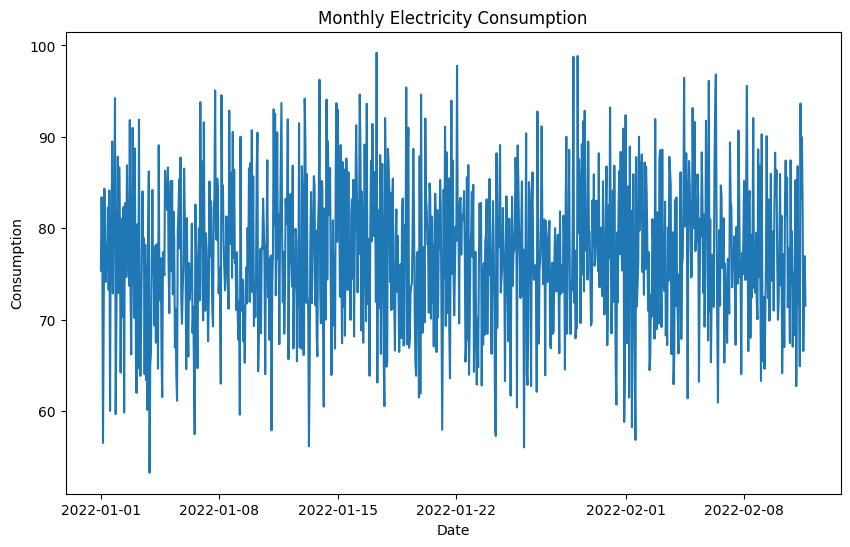

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(data['EnergyConsumption'])
plt.title("Monthly Electricity Consumption")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.show()

<Figure size 1500x800 with 0 Axes>

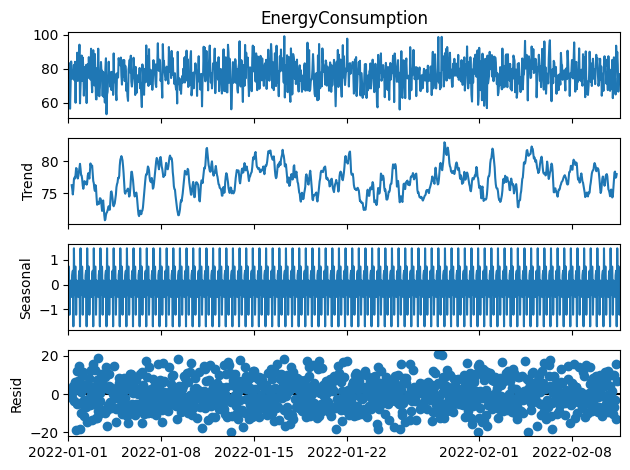

In [35]:
plt.figure(figsize=(15, 8))
decomposition = seasonal_decompose(data['EnergyConsumption'], model='additive', period=12)
decomposition.plot()
plt.show()

<Figure size 1500x800 with 0 Axes>

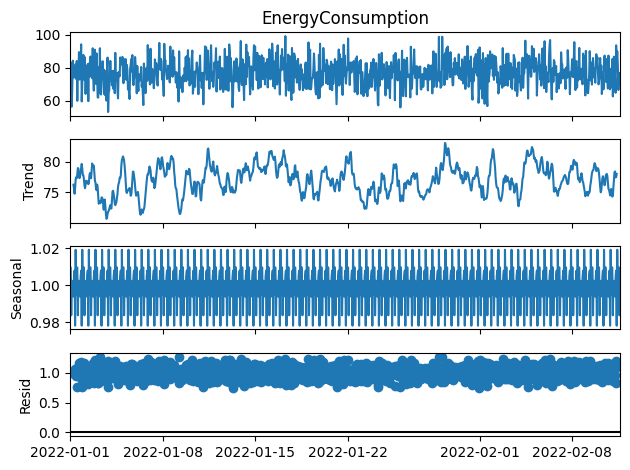

In [36]:
plt.figure(figsize=(15, 8))
decomposition = seasonal_decompose(data['EnergyConsumption'], model='multiplicative', period=12)
decomposition.plot()
plt.show()

In [37]:
train_size = int(len(data) * 0.8)

train = data.iloc[:train_size]
test = data.iloc[train_size:]

<Figure size 1000x600 with 0 Axes>

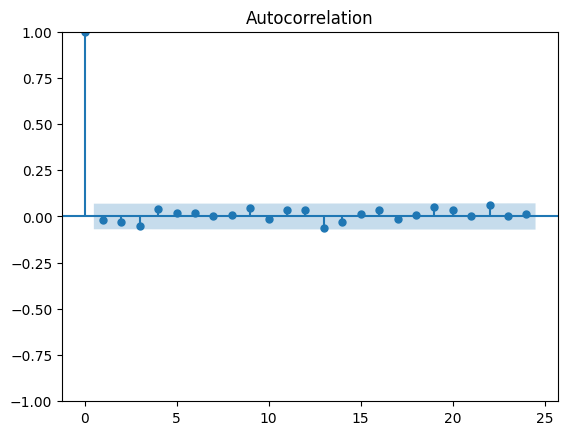

<Figure size 1000x600 with 0 Axes>

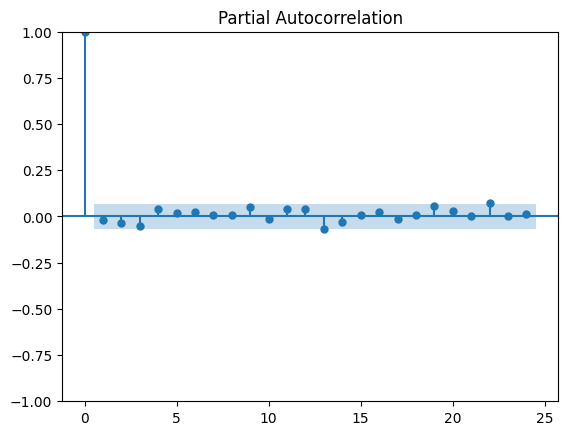

In [39]:
plt.figure(figsize=(10, 6))
plot_acf(train['EnergyConsumption'], lags=24)
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(train['EnergyConsumption'], lags=24)
plt.show()

In [40]:
sarima_model = SARIMAX(
    train['EnergyConsumption'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12)
)

sarima_result = sarima_model.fit()
print(sarima_result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                  EnergyConsumption   No. Observations:                  800
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2806.207
Date:                            Sat, 07 Feb 2026   AIC                           5622.414
Time:                                    04:25:43   BIC                           5645.755
Sample:                                01-01-2022   HQIC                          5631.388
                                     - 02-03-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0161      0.036     -0.445      0.656      -0.087       0.055
ma.L1         -0.9910      0.008   

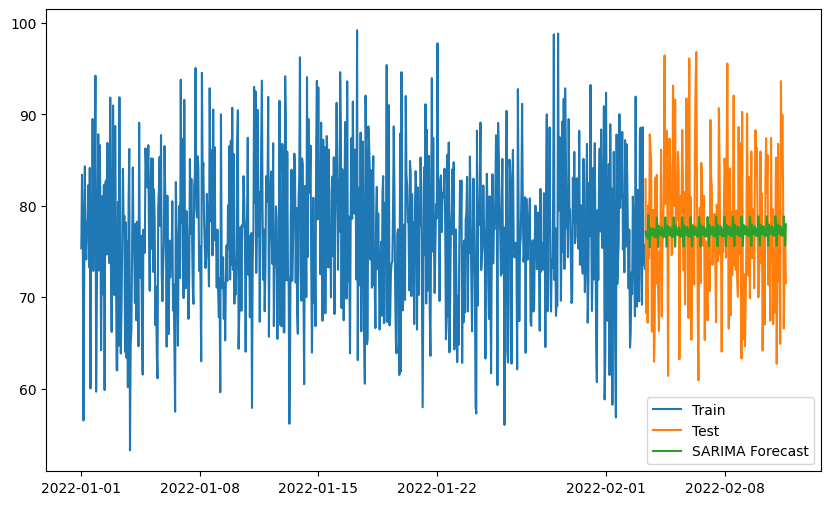

In [41]:
sarima_forecast = sarima_result.forecast(steps=len(test))

plt.figure(figsize=(10, 6))
plt.plot(train['EnergyConsumption'], label='Train')
plt.plot(test['EnergyConsumption'], label='Test')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')
plt.legend()
plt.show()

In [42]:
sarimax_model = SARIMAX(train['EnergyConsumption'],exog=train[['Temperature']],order=(1, 1, 1),seasonal_order=(1, 1, 1, 12))
sarimax_result = sarimax_model.fit()
print(sarimax_result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                  EnergyConsumption   No. Observations:                  800
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2552.919
Date:                            Sat, 07 Feb 2026   AIC                           5117.839
Time:                                    04:26:16   BIC                           5145.848
Sample:                                01-01-2022   HQIC                          5128.607
                                     - 02-03-2022                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature     1.9969      0.076     26.154      0.000       1.847       2.147
ar.L1           0.0018      0.03

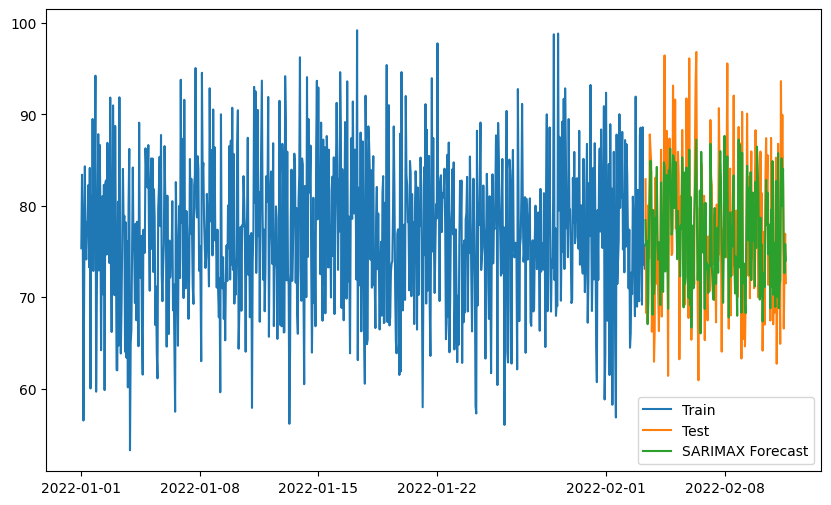

In [43]:
sarimax_forecast = sarimax_result.forecast(
    steps=len(test),
    exog=test[['Temperature']]
)

plt.figure(figsize=(10, 6))
plt.plot(train['EnergyConsumption'], label='Train')
plt.plot(test['EnergyConsumption'], label='Test')
plt.plot(test.index, sarimax_forecast, label='SARIMAX Forecast')
plt.legend()
plt.show()

In [44]:
def evaluate_model(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

sarima_mae, sarima_rmse, sarima_mape = evaluate_model(test['EnergyConsumption'], sarima_forecast)
sarimax_mae, sarimax_rmse, sarimax_mape = evaluate_model(test['EnergyConsumption'], sarimax_forecast)

results = pd.DataFrame({
    'Model': ['SARIMA', 'SARIMAX'],
    'MAE': [sarima_mae, sarimax_mae],
    'RMSE': [sarima_rmse, sarimax_rmse],
    'MAPE (%)': [sarima_mape, sarimax_mape]
})

print(results)

     Model       MAE      RMSE  MAPE (%)
0   SARIMA  6.365894  7.839572  8.267474
1  SARIMAX  4.350706  5.394962  5.657468


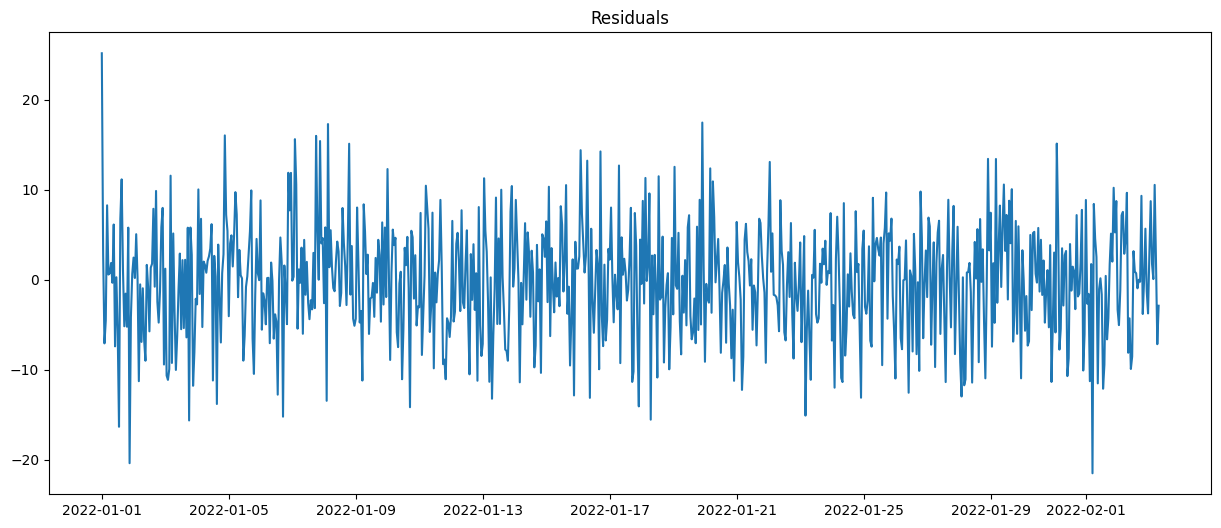

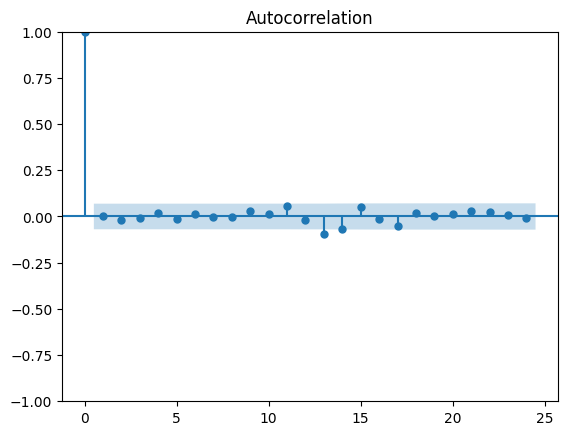

In [50]:
residuals = sarimax_result.resid

plt.figure(figsize=(15, 6))
plt.plot(residuals)
plt.title("Residuals")
plt.show()

plot_acf(residuals, lags=24)
plt.show()

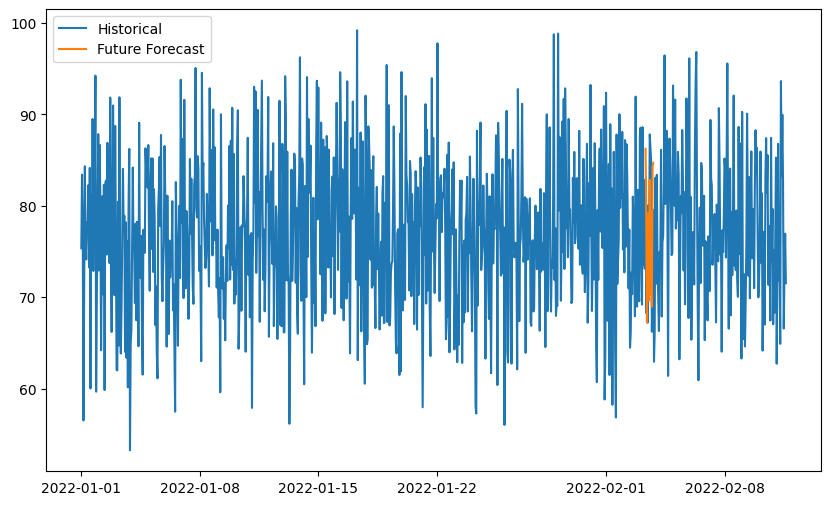

In [47]:
future_temperature = np.random.uniform(low=data['Temperature'].min(),high=data['Temperature'].max(),size=12)
future_forecast = sarimax_result.forecast(steps=12,    exog=future_temperature.reshape(-1, 1))\
plt.figure(figsize=(10, 6))
plt.plot(data['EnergyConsumption'], label='Historical')
plt.plot(future_forecast, label='Future Forecast')
plt.legend()
plt.show()